# Experiment 3: Gamma Sensitivity Analysis - Multiple Networks
## WITH STANDARD VISUALIZATIONS (Matching Experiment 1 & 2 Style)

This notebook analyzes compression benefits across **multiple network realizations** using the **same visualization style** as Experiment 1 and Experiment 2:
- Line plots with mean and percentile bands
- ERLS vs Normalized Gamma
- CR (Conservativeness Ratio) vs Normalized Gamma

### Key Design Choices

- **Multiple Networks**: 30 independent network realizations
- **Adaptive Buffers**: Each network uses α × W_net.sum(axis=1)
- **Gaussian Copula Shocks**: Uses proper copula-based shock generation (Spearman's ρ)
- **Single Shock per Network**: One shock per network (ρ configurable, varying seeds)
- **Normalized Gamma**: Common grid [0, 1] for cross-network comparison

### Differences from Original Experiment 3

- **Visualization**: Uses line plots (like Exp1/2) instead of scatter plots and box plots
- **Shock Generation**: Uses Gaussian Copula (proper dependence structure) instead of factor model
- **Analysis Focus**: Same underlying analysis (gamma sweep with adaptive buffers)
- **Presentation**: Shows trends across gamma values with uncertainty bands

### Technical Notes

The Gaussian Copula shock generator (`copula_shock_generator_fixed.py`) creates proper dependence between node shocks:
- Generates from multivariate normal with target correlation structure
- Applies probability integral transform to get uniform [0,1] shocks
- Spearman's ρ controls rank correlation (more robust than linear correlation)

## 1. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import csr_array
import warnings
warnings.filterwarnings('ignore')

from risk_analysis import (
    generate_compression_network,
    assign_weights_to_network
)
from copula_shock_generator_fixed import generate_gaussian_copula_shocks
from full_payment_algo import full_payment_algo
from CDFD import CDFD_BFF, CDFD_min_cost_pulp

# Styling (matching Experiment 1 & 2)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

colors = {
    'original': '#1f77b4',
    'bff': '#ff7f0e',
    'maximal': '#2ca02c',
}

print("✓ Imports complete")
print("✓ Using Gaussian Copula shock generator (copula_shock_generator_fixed.py)")

✓ Imports complete
✓ Using Gaussian Copula shock generator (copula_shock_generator_fixed.py)


## 2. Parameters

In [2]:
# Network parameters
N_core = 50
num_sources = 2
num_sinks = 3
p = 0.5
N_total = N_core + num_sources + num_sinks

# Monte Carlo parameters
NUM_NETWORKS = 500              # Number of network realizations
NUM_SHOCK_SCENARIOS = 100      # Number of shock realizations per network
base_network_seed = 1000
shock_base_seed = 42
rho = 0.5                      # Shock correlation

# Gamma sweep
NUM_GAMMA_POINTS = 20
GAMMA_MAX_MULTIPLIER = 3       # Maximum gamma as multiple of median buffer

# Tolerance
TOL_ZERO = 1e-5

print("Experimental Configuration")
print("=" * 70)
print(f"Network: {N_total} nodes ({num_sources} sources + {N_core} core + {num_sinks} sinks)")
print(f"Core edge probability: p = {p}")
print(f"Shock correlation: ρ = {rho}")
print()
print(f"Networks: {NUM_NETWORKS}")
print(f"Shocks per network: {NUM_SHOCK_SCENARIOS}")
print(f"Gamma points: {NUM_GAMMA_POINTS}")
print(f"Gamma range: [0, {GAMMA_MAX_MULTIPLIER}×median(b)]")
print(f"Total simulations: {NUM_NETWORKS * NUM_SHOCK_SCENARIOS * NUM_GAMMA_POINTS * 3:,}")
print()
print("KEY DIFFERENCE: Using ADAPTIVE buffers (α × W.sum(axis=1))")
print("=" * 70)

Experimental Configuration
Network: 55 nodes (2 sources + 50 core + 3 sinks)
Core edge probability: p = 0.5
Shock correlation: ρ = 0.5

Networks: 500
Shocks per network: 100
Gamma points: 20
Gamma range: [0, 3×median(b)]
Total simulations: 3,000,000

KEY DIFFERENCE: Using ADAPTIVE buffers (α × W.sum(axis=1))


## 3. Helper Functions

In [3]:
def compute_shortfall_adaptive_buffer(W_net, alpha, gamma, epsilon, DeltaP=1.0):
    """Compute system shortfall with adaptive buffer: α × W_net.sum(axis=1)"""
    buffer_vec = alpha * W_net.sum(axis=1)
    e0 = buffer_vec - gamma * epsilon
    L = DeltaP * W_net
    p_bar, *_ = full_payment_algo(L, e0)
    return float(np.asarray(p_bar).ravel().sum())


def find_tipping_alpha(W_net, gamma, epsilon, alpha_min=0.0, alpha_max=100.0,
                       tol=1e-6, max_iterations=50, expand_factor=2.0, alpha_max_limit=1000.0):
    """
    Find minimum α such that R(W, b, ξ) = 0 using adaptive buffers.
    """
    def objective(alpha):
        return compute_shortfall_adaptive_buffer(W_net, alpha, gamma, epsilon)

    # Check boundary conditions
    R_min = objective(alpha_min)
    R_max = objective(alpha_max)

    if R_min <= tol:
        return alpha_min

    # If upper bound insufficient, expand it
    iterations_expand = 0
    while R_max > tol and alpha_max < alpha_max_limit and iterations_expand < 32:
        alpha_max *= expand_factor
        R_max = objective(alpha_max)
        iterations_expand += 1

    if R_max > tol:
        return alpha_max

    # Binary search
    left, right = alpha_min, alpha_max
    iterations = 0

    while right - left > tol and iterations < max_iterations:
        mid = (left + right) / 2
        R_mid = objective(mid)

        if R_mid > tol:
            left = mid
        else:
            right = mid

        iterations += 1

    return (left + right) / 2


print("✓ Helper functions defined")
print("  - compute_shortfall_adaptive_buffer()")
print("  - find_tipping_alpha()")

✓ Helper functions defined
  - compute_shortfall_adaptive_buffer()
  - find_tipping_alpha()


## 4. Generate Network Corpus

Create 30 independent network realizations and compress each using BFF and Maximal methods.

In [4]:
print("Generating network corpus...")
print()

networks_corpus = []

for net_idx in range(NUM_NETWORKS):
    if (net_idx + 1) % 5 == 0:
        print(f"  Processing network {net_idx + 1}/{NUM_NETWORKS}...")

    network_seed = base_network_seed + net_idx

    try:
        # Generate network structure
        W_struct, _, _, _ = generate_compression_network(
            N_core, p, num_sources, num_sinks, seed=network_seed
        )

        # Assign weights
        W_orig = assign_weights_to_network(W_struct, alpha=2.0, scale=1.0)

        # Compress with BFF
        _, D_bff = CDFD_BFF(csr_array(W_orig), TOL_ZERO=TOL_ZERO)

        # Compress with Maximal
        _, D_max = CDFD_min_cost_pulp(csr_array(W_orig), TOL_ZERO=TOL_ZERO)

        # Store network data
        networks_corpus.append({
            'Original': W_orig,
            'BFF': D_bff.toarray(),
            'Maximal': D_max.toarray(),
        })

    except Exception as e:
        print(f"  Network {net_idx + 1} failed: {e}")
        continue

print()
print(f"✓ Network corpus complete: {len(networks_corpus)} networks")
print(f"  Successfully generated: {len(networks_corpus)}/{NUM_NETWORKS}")

Generating network corpus...

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yijie/.pyenv/versions/3.11.12/envs/myenv311/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/8m/tlrl9p6s7371ym2ydbzyxkbw0000gn/T/24833844ffbd43e9a32bc8d51770c501-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/8m/tlrl9p6s7371ym2ydbzyxkbw0000gn/T/24833844ffbd43e9a32bc8d51770c501-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 60 COLUMNS
At line 4099 RHS
At line 4155 BOUNDS
At line 5502 ENDATA
Problem MODEL has 55 rows, 1346 columns and 2692 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 54 (-1) rows, 1321 (-25) columns and 2642 (-50) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 5.5448568e-05 ( 0.0055448568%) - largest zero change 0
0  Obj 208.65804 Primal inf 631.79905 (54)
44  Obj 517.26537 Primal 

## 5. Multi-Network Gamma Sweep

For each network, compute α* (critical buffer multiplier) across gamma values for original and compressed networks.

In [5]:
# Determine gamma_max from first network only (matching Exp1/2)
alpha_representative = 1.0
buffer_first_network = alpha_representative * networks_corpus[0]['Original'].sum(axis=1)
median_buffer = float(np.median(buffer_first_network))
gamma_max = GAMMA_MAX_MULTIPLIER * median_buffer

print(f"Setting gamma range from first network...")
print(f"  Median buffer (network 0): {median_buffer:.2f}")
print(f"  Gamma max: {GAMMA_MAX_MULTIPLIER} × {median_buffer:.2f} = {gamma_max:.2f}")
print()

# Create uniform gamma grid
gamma_values = np.linspace(0, gamma_max, NUM_GAMMA_POINTS)

# Storage for results: (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)
all_alphas = {
    'Original': np.zeros((NUM_NETWORKS, NUM_GAMMA_POINTS, NUM_SHOCK_SCENARIOS)),
    'BFF': np.zeros((NUM_NETWORKS, NUM_GAMMA_POINTS, NUM_SHOCK_SCENARIOS)),
    'Maximal': np.zeros((NUM_NETWORKS, NUM_GAMMA_POINTS, NUM_SHOCK_SCENARIOS))
}

network_sums = {
    'Original': np.zeros(NUM_NETWORKS),
    'BFF': np.zeros(NUM_NETWORKS),
    'Maximal': np.zeros(NUM_NETWORKS)
}

print("Running multi-shock gamma sweep...")
print(f"  Networks: {NUM_NETWORKS}")
print(f"  Gamma points: {NUM_GAMMA_POINTS}")
print(f"  Shocks per network: {NUM_SHOCK_SCENARIOS}")
print(f"  Total evaluations: {NUM_NETWORKS * NUM_GAMMA_POINTS * NUM_SHOCK_SCENARIOS * 3:,}")
print()

for net_idx, net_data in enumerate(networks_corpus):
    if (net_idx + 1) % 5 == 0:
        print(f"  Network {net_idx + 1}/{len(networks_corpus)}...")

    # Store network sums for ERLS calculation (once per network)
    network_sums['Original'][net_idx] = net_data['Original'].sum()
    network_sums['BFF'][net_idx] = net_data['BFF'].sum()
    network_sums['Maximal'][net_idx] = net_data['Maximal'].sum()

    # For each shock scenario
    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        # Generate shock using Gaussian Copula
        shock_seed = shock_base_seed + net_idx * 10000 + shock_idx
        epsilon = generate_gaussian_copula_shocks(
            N_total,
            rho,
            n_samples=1,
            seed=shock_seed,
            target_correlation='spearman'
        ).flatten()  # Returns (1, N_total), flatten to (N_total,)

        # For each gamma value
        for gamma_idx, gamma in enumerate(gamma_values):
            # Original network
            alpha_orig = find_tipping_alpha(net_data['Original'], gamma, epsilon)
            all_alphas['Original'][net_idx, gamma_idx, shock_idx] = alpha_orig

            # BFF compressed
            alpha_bff = find_tipping_alpha(net_data['BFF'], gamma, epsilon)
            all_alphas['BFF'][net_idx, gamma_idx, shock_idx] = alpha_bff

            # Maximal compressed
            alpha_max = find_tipping_alpha(net_data['Maximal'], gamma, epsilon)
            all_alphas['Maximal'][net_idx, gamma_idx, shock_idx] = alpha_max

print()
print(f"✓ Gamma sweep complete")
print(f"  Shape: ({NUM_NETWORKS} networks, {NUM_GAMMA_POINTS} gamma, {NUM_SHOCK_SCENARIOS} shocks)")
print(f"  Using Gaussian Copula with Spearman's ρ = {rho}")

Setting gamma range from first network...
  Median buffer (network 0): 45.60
  Gamma max: 3 × 45.60 = 136.79

Running multi-shock gamma sweep...
  Networks: 500
  Gamma points: 20
  Shocks per network: 100
  Total evaluations: 3,000,000

  Network 5/500...
  Network 10/500...
  Network 15/500...
  Network 20/500...
  Network 25/500...
  Network 30/500...
  Network 35/500...
  Network 40/500...
  Network 45/500...
  Network 50/500...
  Network 55/500...
  Network 60/500...
  Network 65/500...
  Network 70/500...
  Network 75/500...
  Network 80/500...
  Network 85/500...
  Network 90/500...
  Network 95/500...
  Network 100/500...
  Network 105/500...
  Network 110/500...
  Network 115/500...
  Network 120/500...
  Network 125/500...
  Network 130/500...
  Network 135/500...
  Network 140/500...
  Network 145/500...
  Network 150/500...
  Network 155/500...
  Network 160/500...
  Network 165/500...
  Network 170/500...
  Network 175/500...
  Network 180/500...
  Network 185/500...
  Net

## 6. Compute CR and ERLS Metrics (Option 1: Network Variability)

**Step 1**: Average over shocks for each network  
**Step 2**: Compute CR and ERLS statistics across networks

This shows how network topology affects compression benefits.

In [6]:
print("Computing CR and ERLS metrics (Option 1: Network Variability)...")
print("=" * 70)
print("Step 1: Average over shocks for each network")
print("Step 2: Compute CR and ERLS per network, then statistics across networks")
print()

gamma_normalized = gamma_values / gamma_max if gamma_max > 0 else gamma_values

results_option1 = {
    'gamma_values': gamma_values,
    'gamma_normalized': gamma_normalized,
    'p': p,
    'rho': rho,
    'methods': {}
}

# Compute metrics for each method
for method_name in ['Original', 'BFF', 'Maximal']:
    # Get alphas: (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)
    method_alphas = all_alphas[method_name]
    original_alphas = all_alphas['Original']

    # STEP 1: Average over shocks (axis=2) -> (NUM_NETWORKS, NUM_GAMMA)
    method_alphas_per_network = method_alphas.mean(axis=2)
    original_alphas_per_network = original_alphas.mean(axis=2)

    # Network flow statistics
    flow_retained_mean = (network_sums[method_name] / network_sums['Original']).mean()

    if method_name != 'Original':
        # CR per network (averaged over shocks first)
        cr_per_network = method_alphas_per_network / original_alphas_per_network  # (NUM_NETWORKS, NUM_GAMMA)

        # ERLS per network (using correct formula from original Exp3)
        original_sums_expanded = network_sums['Original'][:, np.newaxis]  # (NUM_NETWORKS, 1)
        method_sums_expanded = network_sums[method_name][:, np.newaxis]

        numerator = original_alphas_per_network * original_sums_expanded - method_alphas_per_network * method_sums_expanded
        denominator = original_alphas_per_network * original_sums_expanded
        erls_per_network = numerator / denominator

        # STEP 2: Compute statistics across networks (axis=0)
        cr_mean = np.nanmean(cr_per_network, axis=0)
        cr_median = np.nanmedian(cr_per_network, axis=0)
        cr_std = np.nanstd(cr_per_network, axis=0)
        cr_p25 = np.nanpercentile(cr_per_network, 25, axis=0)
        cr_p75 = np.nanpercentile(cr_per_network, 75, axis=0)

        erls_mean = np.nanmean(erls_per_network, axis=0)
        erls_median = np.nanmedian(erls_per_network, axis=0)
        erls_std = np.nanstd(erls_per_network, axis=0)
        erls_p25 = np.nanpercentile(erls_per_network, 25, axis=0)
        erls_p75 = np.nanpercentile(erls_per_network, 75, axis=0)

        alpha_mean = np.mean(method_alphas_per_network, axis=0)
        alpha_median = np.median(method_alphas_per_network, axis=0)
        alpha_std = np.std(method_alphas_per_network, axis=0)
        
        # Store per-network data for trajectory plots
        cr_all_networks = cr_per_network      # (NUM_NETWORKS, NUM_GAMMA)
        erls_all_networks = erls_per_network  # (NUM_NETWORKS, NUM_GAMMA)
    else:
        cr_mean = np.ones(NUM_GAMMA_POINTS)
        cr_median = np.ones(NUM_GAMMA_POINTS)
        cr_std = np.zeros(NUM_GAMMA_POINTS)
        cr_p25 = np.ones(NUM_GAMMA_POINTS)
        cr_p75 = np.ones(NUM_GAMMA_POINTS)

        erls_mean = np.zeros(NUM_GAMMA_POINTS)
        erls_median = np.zeros(NUM_GAMMA_POINTS)
        erls_std = np.zeros(NUM_GAMMA_POINTS)
        erls_p25 = np.zeros(NUM_GAMMA_POINTS)
        erls_p75 = np.zeros(NUM_GAMMA_POINTS)

        alpha_mean = np.mean(method_alphas_per_network, axis=0)
        alpha_median = np.median(method_alphas_per_network, axis=0)
        alpha_std = np.std(method_alphas_per_network, axis=0)
        
        cr_all_networks = None
        erls_all_networks = None

    # Store results
    results_option1['methods'][method_name] = {
        'alpha_mean': alpha_mean,
        'alpha_median': alpha_median,
        'alpha_std': alpha_std,
        'cr_mean': cr_mean,
        'cr_median': cr_median,
        'cr_std': cr_std,
        'cr_p25': cr_p25,
        'cr_p75': cr_p75,
        'erls_mean': erls_mean,
        'erls_median': erls_median,
        'erls_std': erls_std,
        'erls_p25': erls_p25,
        'erls_p75': erls_p75,
        'flow_retained': flow_retained_mean,
        'cr_all_networks': cr_all_networks,      # (NUM_NETWORKS, NUM_GAMMA) for trajectory plots
        'erls_all_networks': erls_all_networks,  # (NUM_NETWORKS, NUM_GAMMA) for trajectory plots
    }

print("=" * 70)
print("✓ Option 1 metrics computed (Network Variability)")
print()
for method_name in ['BFF', 'Maximal']:
    print(f"{method_name}:")
    print(f"  Mean CR: {results_option1['methods'][method_name]['cr_mean'].mean():.3f}")
    print(f"  Median CR: {results_option1['methods'][method_name]['cr_median'].mean():.3f}")
    print(f"  Mean ERLS: {results_option1['methods'][method_name]['erls_mean'].mean():.3f}")
    print(f"  Median ERLS: {results_option1['methods'][method_name]['erls_median'].mean():.3f}")
    print(f"  Flow retained: {results_option1['methods'][method_name]['flow_retained']:.3f}")
    print()

Computing CR and ERLS metrics (Option 1: Network Variability)...
Step 1: Average over shocks for each network
Step 2: Compute CR and ERLS per network, then statistics across networks

✓ Option 1 metrics computed (Network Variability)

BFF:
  Mean CR: 30.808
  Median CR: 13.763
  Mean ERLS: -6.884
  Median ERLS: -2.568
  Flow retained: 0.258

Maximal:
  Mean CR: 29.525
  Median CR: 16.470
  Mean ERLS: -5.172
  Median ERLS: -2.527
  Flow retained: 0.214



## 7. Visualization 1: ERLS vs Normalized Gamma (Option 1)

**Network Variability**: Shows median (solid) and mean (dashed) with 25-75 percentile bands.

Creating ERLS vs Gamma visualization (Option 1: Network Variability)...
✓ Saved: figure_erls_vs_gamma_option1_p0.50_rho0.50.png


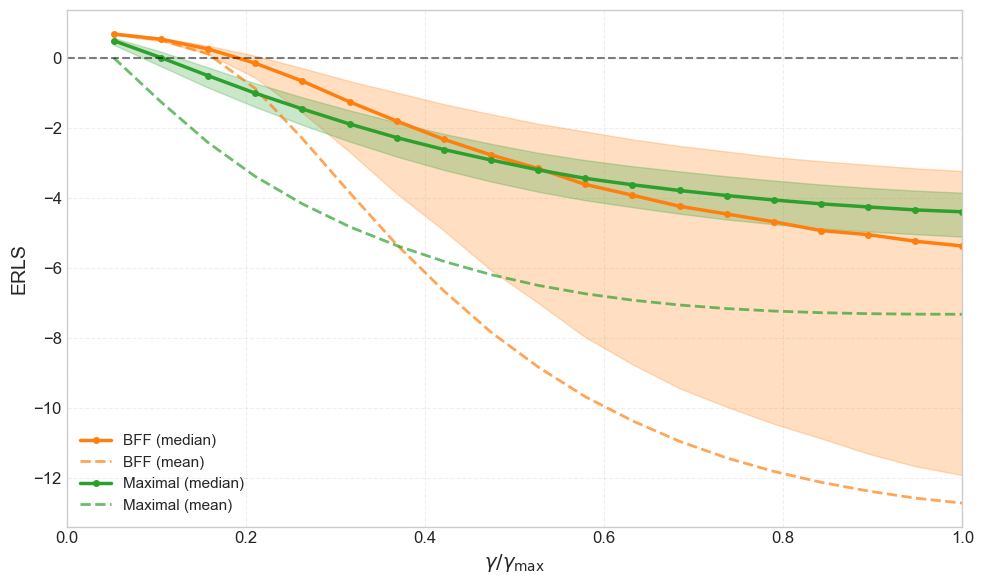

In [7]:
print("Creating ERLS vs Gamma visualization (Option 1: Network Variability)...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask = gamma_normalized > 0  # Exclude gamma = 0

for method_name in ['BFF', 'Maximal']:
    erls_median = results_option1['methods'][method_name]['erls_median'][mask]
    erls_mean = results_option1['methods'][method_name]['erls_mean'][mask]
    erls_p25 = results_option1['methods'][method_name]['erls_p25'][mask]
    erls_p75 = results_option1['methods'][method_name]['erls_p75'][mask]

    # Plot median line (solid)
    ax.plot(gamma_normalized[mask], erls_median, linewidth=2.5,
            label=f'{method_name} (median)', marker='o', markersize=4, 
            markevery=max(1, len(gamma_normalized[mask])//10),
            color=colors[method_name.lower()])
    
    # Plot mean line (dashed)
    ax.plot(gamma_normalized[mask], erls_mean, linewidth=2,
            linestyle='--', alpha=0.7,
            label=f'{method_name} (mean)',
            color=colors[method_name.lower()])

    # Fill 25-75 percentile band
    ax.fill_between(gamma_normalized[mask], erls_p25, erls_p75,
                    alpha=0.25, color=colors[method_name.lower()])

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xlabel(r'$\gamma / \gamma_{\mathrm{max}}$', fontsize=14)
ax.set_ylabel(r'ERLS', fontsize=14)
# ax.set_title(f'ERLS vs Normalized Gamma - Network Variability (p={p:.2f}, ρ={rho:.2f})', 
#              fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(f'experiment3_results/Experiment3_figure_erls_vs_gamma_option1_p{p:.2f}_rho{rho:.2f}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: figure_erls_vs_gamma_option1_p{p:.2f}_rho{rho:.2f}.png")
plt.show()

## 7b. Individual Network Trajectories: ERLS (Option 1)

Show individual network responses for ERLS metric (after averaging over shocks).

Creating individual ERLS trajectory plot (Option 1: Network Variability)...
✓ Saved: Experiment3_ERLS_individual_trajectory_option1_p0.50_rho0.50.png


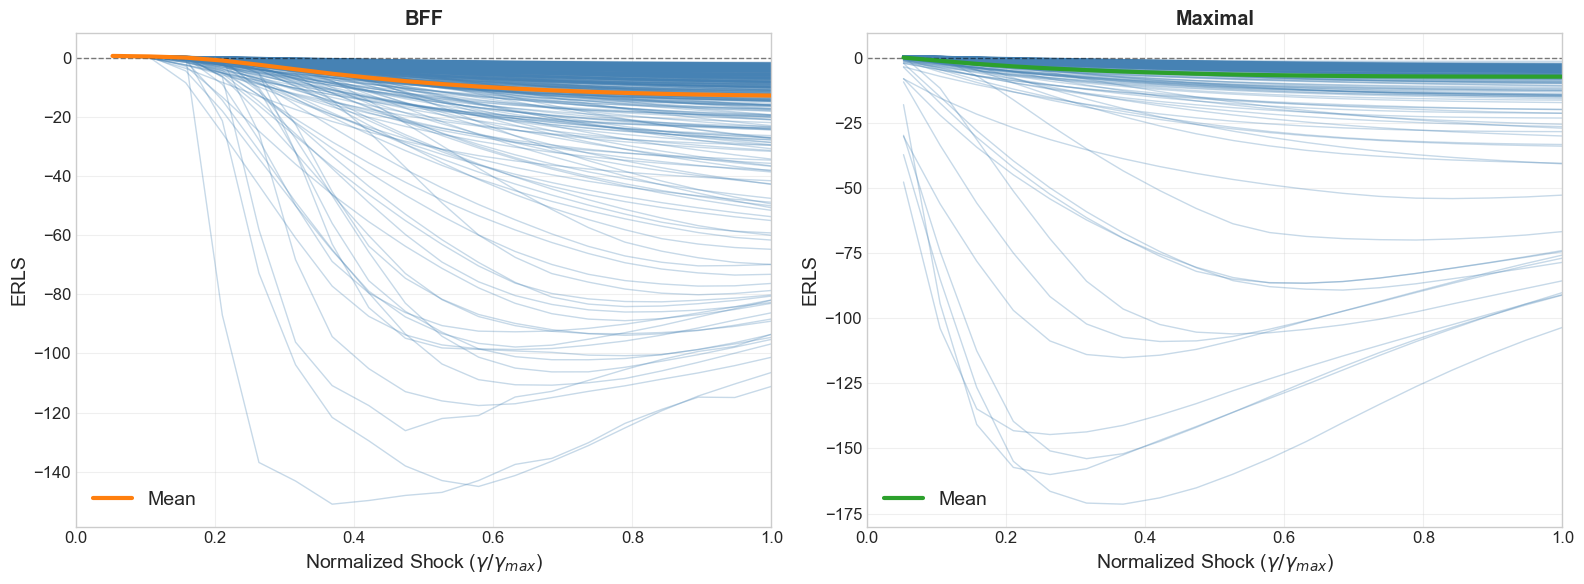

In [8]:
print("Creating individual ERLS trajectory plot (Option 1: Network Variability)...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

mask = gamma_normalized > 0  # Exclude gamma = 0

# Plot 1: BFF
if 'BFF' in results_option1['methods']:
    erls_networks = results_option1['methods']['BFF']['erls_all_networks']
    erls_mean = results_option1['methods']['BFF']['erls_mean']
    
    # Plot individual network trajectories
    for net_idx in range(NUM_NETWORKS):
        ax1.plot(gamma_normalized[mask], erls_networks[net_idx, mask],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax1.plot(gamma_normalized[mask], erls_mean[mask],
            linewidth=3, color='#ff7f0e', label='Mean', zorder=10)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax1.set_ylabel(r'ERLS', fontsize=14)
    ax1.set_title(f'BFF', fontweight='bold')
    ax1.legend(fontsize=14, loc='best')
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 1)

# Plot 2: Maximal
if 'Maximal' in results_option1['methods']:
    erls_networks = results_option1['methods']['Maximal']['erls_all_networks']
    erls_mean = results_option1['methods']['Maximal']['erls_mean']
    
    # Plot individual network trajectories
    for net_idx in range(NUM_NETWORKS):
        ax2.plot(gamma_normalized[mask], erls_networks[net_idx, mask],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax2.plot(gamma_normalized[mask], erls_mean[mask],
            linewidth=3, color='#2ca02c', label='Mean', zorder=10)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax2.set_ylabel(r'ERLS', fontsize=14)
    ax2.set_title(f'Maximal', fontweight='bold')
    ax2.legend(fontsize=14, loc='best')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(f'experiment3_results/Experiment3_ERLS_individual_trajectory_option1_p{p:.2f}_rho{rho:.2f}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: Experiment3_ERLS_individual_trajectory_option1_p{p:.2f}_rho{rho:.2f}.png")
plt.show()

## 8. Visualization 2: CR vs Normalized Gamma (Option 1)

**Network Variability**: Shows median (solid) and mean (dashed) with 25-75 percentile bands.

Creating CR vs Gamma visualization (Option 1: Network Variability)...
✓ Saved: figure_cr_vs_gamma_option1_p0.50_rho0.50.png


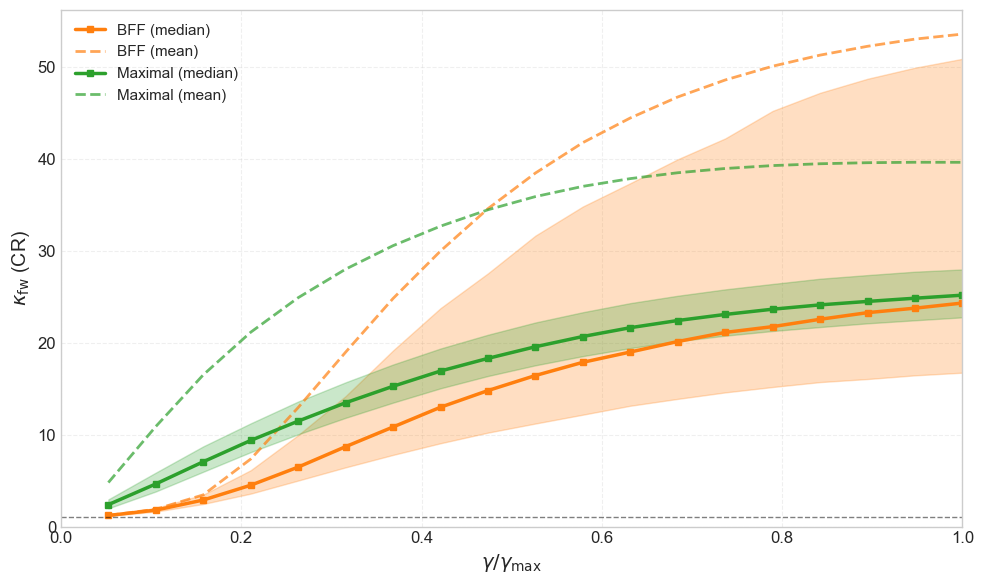

In [9]:
print("Creating CR vs Gamma visualization (Option 1: Network Variability)...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask = gamma_normalized > 0  # Exclude gamma = 0

for method_name in ['BFF', 'Maximal']:
    cr_median = results_option1['methods'][method_name]['cr_median'][mask]
    cr_mean = results_option1['methods'][method_name]['cr_mean'][mask]
    cr_p25 = results_option1['methods'][method_name]['cr_p25'][mask]
    cr_p75 = results_option1['methods'][method_name]['cr_p75'][mask]

    # Plot median line (solid)
    ax.plot(gamma_normalized[mask], cr_median, linewidth=2.5,
            label=f'{method_name} (median)', marker='s', markersize=4,
            markevery=max(1, len(gamma_normalized[mask])//10),
            color=colors[method_name.lower()])
    
    # Plot mean line (dashed)
    ax.plot(gamma_normalized[mask], cr_mean, linewidth=2,
            linestyle='--', alpha=0.7,
            label=f'{method_name} (mean)',
            color=colors[method_name.lower()])

    # Fill 25-75 percentile band
    ax.fill_between(gamma_normalized[mask], cr_p25, cr_p75,
                    alpha=0.25, color=colors[method_name.lower()])

ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel(r'$\gamma / \gamma_{\mathrm{max}}$', fontsize=14)
ax.set_ylabel(r'$\kappa_{\mathrm{fw}}$ (CR)', fontsize=14)
# ax.set_title(f'Conservativeness Ratio vs Normalized Gamma - Network Variability (p={p:.2f}, ρ={rho:.2f})',
#              fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(f'experiment3_results/Experiment3_figure_cr_vs_gamma_option1_p{p:.2f}_rho{rho:.2f}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: figure_cr_vs_gamma_option1_p{p:.2f}_rho{rho:.2f}.png")
plt.show()

## 8b. Individual Network Trajectories: CR (Option 1)

Show individual network responses for CR metric (after averaging over shocks).

Creating individual CR trajectory plot (Option 1: Network Variability)...
✓ Saved: Experiment3_CR_individual_trajectory_option1_p0.50_rho0.50.png


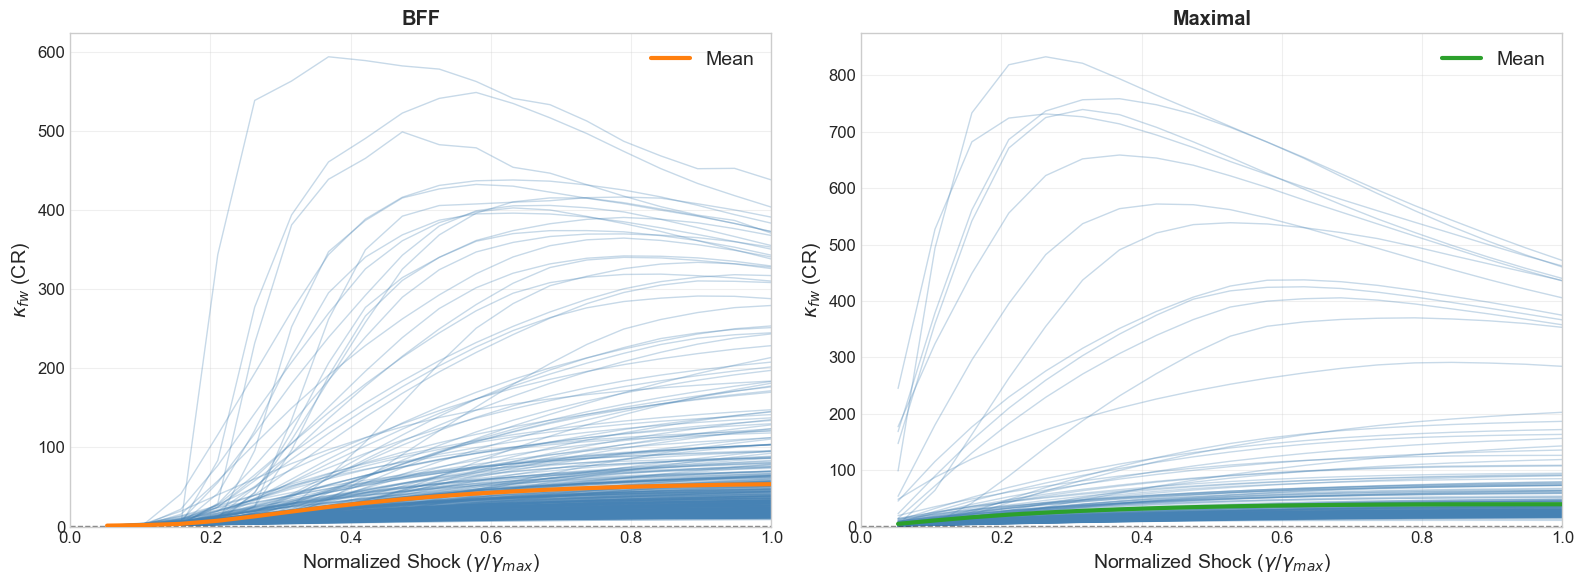

In [10]:
print("Creating individual CR trajectory plot (Option 1: Network Variability)...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

mask = gamma_normalized > 0  # Exclude gamma = 0

# Plot 1: BFF
if 'BFF' in results_option1['methods']:
    cr_networks = results_option1['methods']['BFF']['cr_all_networks']
    cr_mean = results_option1['methods']['BFF']['cr_mean']
    
    # Plot individual network trajectories
    for net_idx in range(NUM_NETWORKS):
        ax1.plot(gamma_normalized[mask], cr_networks[net_idx, mask],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax1.plot(gamma_normalized[mask], cr_mean[mask],
            linewidth=3, color='#ff7f0e', label='Mean', zorder=10)
    ax1.axhline(1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax1.set_ylabel(r'$\kappa_{fw}$ (CR)', fontsize=14)
    ax1.set_title(f'BFF', fontweight='bold')
    ax1.legend(fontsize=14, loc='best')
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(bottom=0)

# Plot 2: Maximal
if 'Maximal' in results_option1['methods']:
    cr_networks = results_option1['methods']['Maximal']['cr_all_networks']
    cr_mean = results_option1['methods']['Maximal']['cr_mean']
    
    # Plot individual network trajectories
    for net_idx in range(NUM_NETWORKS):
        ax2.plot(gamma_normalized[mask], cr_networks[net_idx, mask],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax2.plot(gamma_normalized[mask], cr_mean[mask],
            linewidth=3, color='#2ca02c', label='Mean', zorder=10)
    ax2.axhline(1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax2.set_ylabel(r'$\kappa_{fw}$ (CR)', fontsize=14)
    ax2.set_title(f'Maximal', fontweight='bold')
    ax2.legend(fontsize=14, loc='best')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(f'experiment3_results/Experiment3_CR_individual_trajectory_option1_p{p:.2f}_rho{rho:.2f}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: Experiment3_CR_individual_trajectory_option1_p{p:.2f}_rho{rho:.2f}.png")
plt.show()

## 9. Compute CR and ERLS Metrics (Option 2: Shock Variability)

**Step 1**: Average over networks for each shock scenario  
**Step 2**: Compute CR and ERLS statistics across shock scenarios

This shows how shock randomness affects compression benefits.

In [11]:
print("Computing CR and ERLS metrics (Option 2: Shock Variability)...")
print("=" * 70)
print("Step 1: Average over networks for each shock scenario")
print("Step 2: Compute CR and ERLS per shock, then statistics across shock scenarios")
print()

results_option2 = {
    'gamma_values': gamma_values,
    'gamma_normalized': gamma_normalized,
    'p': p,
    'rho': rho,
    'methods': {}
}

# Compute metrics for each method
for method_name in ['Original', 'BFF', 'Maximal']:
    # Get alphas: (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)
    method_alphas = all_alphas[method_name]
    original_alphas = all_alphas['Original']

    # STEP 1: Average over networks (axis=0) -> (NUM_GAMMA, NUM_SHOCKS)
    method_alphas_per_shock = method_alphas.mean(axis=0)
    original_alphas_per_shock = original_alphas.mean(axis=0)

    # Network flow statistics (same as option1)
    flow_retained_mean = (network_sums[method_name] / network_sums['Original']).mean()

    if method_name != 'Original':
        # CR per shock (averaged over networks first)
        cr_per_shock = method_alphas_per_shock / original_alphas_per_shock  # (NUM_GAMMA, NUM_SHOCKS)

        # ERLS per shock (using correct formula from original Exp3)
        # Need to average network sums across networks
        original_sum_mean = network_sums['Original'].mean()
        method_sum_mean = network_sums[method_name].mean()

        numerator = original_alphas_per_shock * original_sum_mean - method_alphas_per_shock * method_sum_mean
        denominator = original_alphas_per_shock * original_sum_mean
        erls_per_shock = numerator / denominator

        # STEP 2: Compute statistics across shocks (axis=1)
        cr_mean = np.nanmean(cr_per_shock, axis=1)
        cr_median = np.nanmedian(cr_per_shock, axis=1)
        cr_std = np.nanstd(cr_per_shock, axis=1)
        cr_p25 = np.nanpercentile(cr_per_shock, 25, axis=1)
        cr_p75 = np.nanpercentile(cr_per_shock, 75, axis=1)

        erls_mean = np.nanmean(erls_per_shock, axis=1)
        erls_median = np.nanmedian(erls_per_shock, axis=1)
        erls_std = np.nanstd(erls_per_shock, axis=1)
        erls_p25 = np.nanpercentile(erls_per_shock, 25, axis=1)
        erls_p75 = np.nanpercentile(erls_per_shock, 75, axis=1)

        alpha_mean = np.mean(method_alphas_per_shock, axis=1)
        alpha_median = np.median(method_alphas_per_shock, axis=1)
        alpha_std = np.std(method_alphas_per_shock, axis=1)
        
        # Store per-shock data for trajectory plots
        cr_all_shocks = cr_per_shock      # (NUM_GAMMA, NUM_SHOCKS)
        erls_all_shocks = erls_per_shock  # (NUM_GAMMA, NUM_SHOCKS)
    else:
        cr_mean = np.ones(NUM_GAMMA_POINTS)
        cr_median = np.ones(NUM_GAMMA_POINTS)
        cr_std = np.zeros(NUM_GAMMA_POINTS)
        cr_p25 = np.ones(NUM_GAMMA_POINTS)
        cr_p75 = np.ones(NUM_GAMMA_POINTS)

        erls_mean = np.zeros(NUM_GAMMA_POINTS)
        erls_median = np.zeros(NUM_GAMMA_POINTS)
        erls_std = np.zeros(NUM_GAMMA_POINTS)
        erls_p25 = np.zeros(NUM_GAMMA_POINTS)
        erls_p75 = np.zeros(NUM_GAMMA_POINTS)

        alpha_mean = np.mean(method_alphas_per_shock, axis=1)
        alpha_median = np.median(method_alphas_per_shock, axis=1)
        alpha_std = np.std(method_alphas_per_shock, axis=1)
        
        cr_all_shocks = None
        erls_all_shocks = None

    # Store results
    results_option2['methods'][method_name] = {
        'alpha_mean': alpha_mean,
        'alpha_median': alpha_median,
        'alpha_std': alpha_std,
        'cr_mean': cr_mean,
        'cr_median': cr_median,
        'cr_std': cr_std,
        'cr_p25': cr_p25,
        'cr_p75': cr_p75,
        'erls_mean': erls_mean,
        'erls_median': erls_median,
        'erls_std': erls_std,
        'erls_p25': erls_p25,
        'erls_p75': erls_p75,
        'flow_retained': flow_retained_mean,
        'cr_all_shocks': cr_all_shocks,      # (NUM_GAMMA, NUM_SHOCKS) for trajectory plots
        'erls_all_shocks': erls_all_shocks,  # (NUM_GAMMA, NUM_SHOCKS) for trajectory plots
    }

print("=" * 70)
print("✓ Option 2 metrics computed (Shock Variability)")
print()
for method_name in ['BFF', 'Maximal']:
    print(f"{method_name}:")
    print(f"  Mean CR: {results_option2['methods'][method_name]['cr_mean'].mean():.3f}")
    print(f"  Median CR: {results_option2['methods'][method_name]['cr_median'].mean():.3f}")
    print(f"  Mean ERLS: {results_option2['methods'][method_name]['erls_mean'].mean():.3f}")
    print(f"  Median ERLS: {results_option2['methods'][method_name]['erls_median'].mean():.3f}")
    print(f"  Flow retained: {results_option2['methods'][method_name]['flow_retained']:.3f}")
    print()

Computing CR and ERLS metrics (Option 2: Shock Variability)...
Step 1: Average over networks for each shock scenario
Step 2: Compute CR and ERLS per shock, then statistics across shock scenarios

✓ Option 2 metrics computed (Shock Variability)

BFF:
  Mean CR: 30.926
  Median CR: 30.793
  Mean ERLS: -6.990
  Median ERLS: -6.956
  Flow retained: 0.258

Maximal:
  Mean CR: 29.643
  Median CR: 29.723
  Mean ERLS: -5.337
  Median ERLS: -5.354
  Flow retained: 0.214



Creating ERLS vs Gamma visualization (Option 2: Shock Variability)...
✓ Saved: figure_erls_vs_gamma_option2_p0.50_rho0.50.png


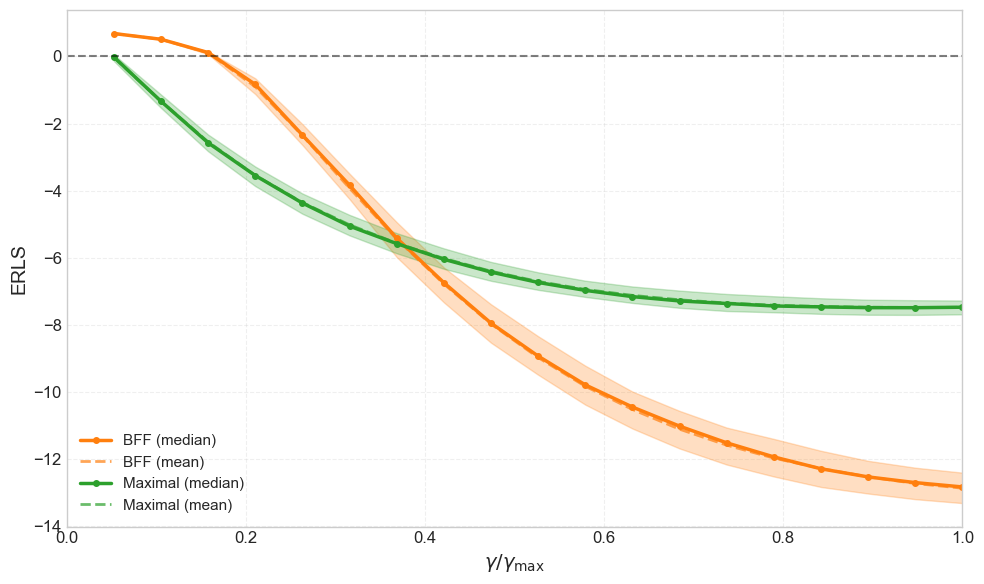

In [12]:
print("Creating ERLS vs Gamma visualization (Option 2: Shock Variability)...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask = gamma_normalized > 0  # Exclude gamma = 0

for method_name in ['BFF', 'Maximal']:
    erls_median = results_option2['methods'][method_name]['erls_median'][mask]
    erls_mean = results_option2['methods'][method_name]['erls_mean'][mask]
    erls_p25 = results_option2['methods'][method_name]['erls_p25'][mask]
    erls_p75 = results_option2['methods'][method_name]['erls_p75'][mask]

    # Plot median line (solid)
    ax.plot(gamma_normalized[mask], erls_median, linewidth=2.5,
            label=f'{method_name} (median)', marker='o', markersize=4, 
            markevery=max(1, len(gamma_normalized[mask])//10),
            color=colors[method_name.lower()])
    
    # Plot mean line (dashed)
    ax.plot(gamma_normalized[mask], erls_mean, linewidth=2,
            linestyle='--', alpha=0.7,
            label=f'{method_name} (mean)',
            color=colors[method_name.lower()])

    # Fill 25-75 percentile band
    ax.fill_between(gamma_normalized[mask], erls_p25, erls_p75,
                    alpha=0.25, color=colors[method_name.lower()])

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xlabel(r'$\gamma / \gamma_{\mathrm{max}}$', fontsize=14)
ax.set_ylabel(r'ERLS', fontsize=14)
# ax.set_title(f'ERLS vs Normalized Gamma - Shock Variability (p={p:.2f}, ρ={rho:.2f})', 
             # fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(f'experiment3_results/Experiment3_figure_erls_vs_gamma_option2_p{p:.2f}_rho{rho:.2f}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: figure_erls_vs_gamma_option2_p{p:.2f}_rho{rho:.2f}.png")
plt.show()

## 10b. Individual Shock Trajectories: ERLS (Option 2)

Show individual shock scenario responses for ERLS metric (after averaging over networks).

Creating individual ERLS trajectory plot (Option 2: Shock Variability)...
✓ Saved: Experiment3_ERLS_individual_trajectory_option2_p0.50_rho0.50.png


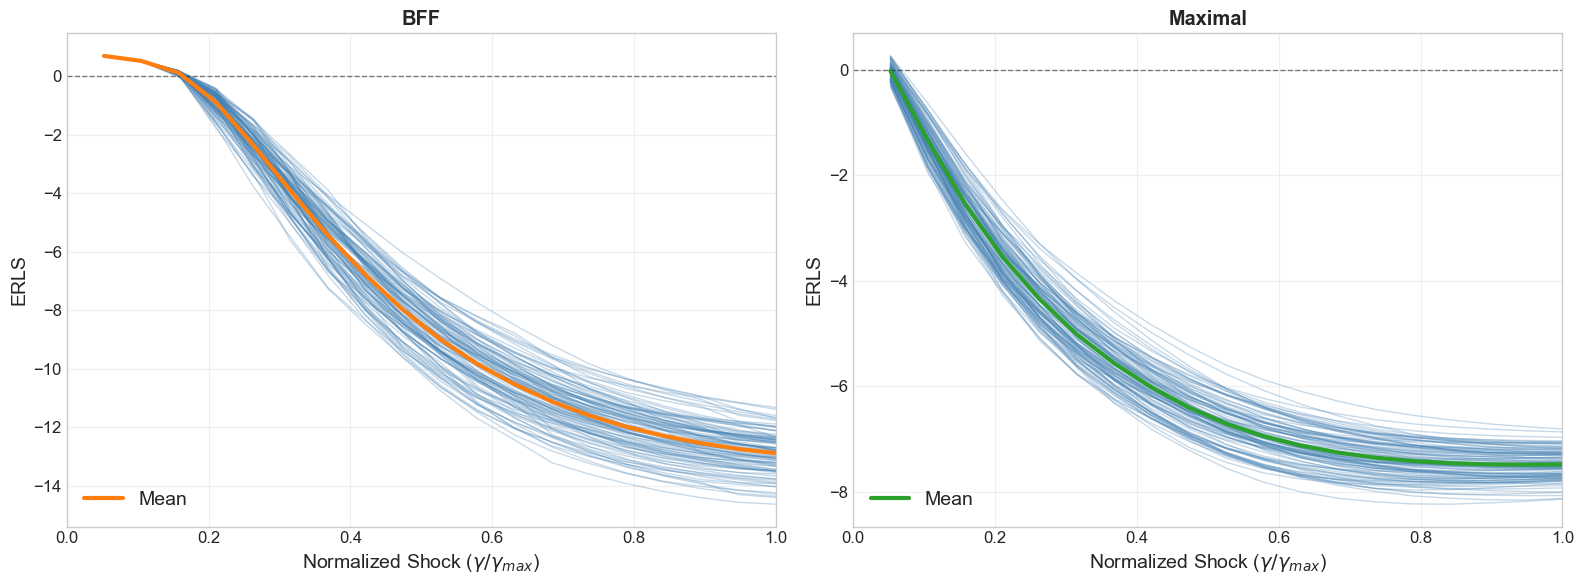

In [13]:
print("Creating individual ERLS trajectory plot (Option 2: Shock Variability)...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

mask = gamma_normalized > 0  # Exclude gamma = 0

# Plot 1: BFF
if 'BFF' in results_option2['methods']:
    erls_shocks = results_option2['methods']['BFF']['erls_all_shocks']  # (NUM_GAMMA, NUM_SHOCKS)
    erls_mean = results_option2['methods']['BFF']['erls_mean']
    
    # Plot individual shock trajectories
    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        ax1.plot(gamma_normalized[mask], erls_shocks[mask, shock_idx],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax1.plot(gamma_normalized[mask], erls_mean[mask],
            linewidth=3, color='#ff7f0e', label='Mean', zorder=10)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax1.set_ylabel(r'ERLS', fontsize=14)
    ax1.set_title(f'BFF', fontweight='bold')
    ax1.legend(fontsize=14, loc='best')
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 1)

# Plot 2: Maximal
if 'Maximal' in results_option2['methods']:
    erls_shocks = results_option2['methods']['Maximal']['erls_all_shocks']  # (NUM_GAMMA, NUM_SHOCKS)
    erls_mean = results_option2['methods']['Maximal']['erls_mean']
    
    # Plot individual shock trajectories
    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        ax2.plot(gamma_normalized[mask], erls_shocks[mask, shock_idx],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax2.plot(gamma_normalized[mask], erls_mean[mask],
            linewidth=3, color='#2ca02c', label='Mean', zorder=10)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax2.set_ylabel(r'ERLS', fontsize=14)
    ax2.set_title(f'Maximal', fontweight='bold')
    ax2.legend(fontsize=14, loc='best')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(f'experiment3_results/Experiment3_ERLS_individual_trajectory_option2_p{p:.2f}_rho{rho:.2f}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: Experiment3_ERLS_individual_trajectory_option2_p{p:.2f}_rho{rho:.2f}.png")
plt.show()

Creating CR vs Gamma visualization (Option 2: Shock Variability)...
✓ Saved: figure_cr_vs_gamma_option2_p0.50_rho0.50.png


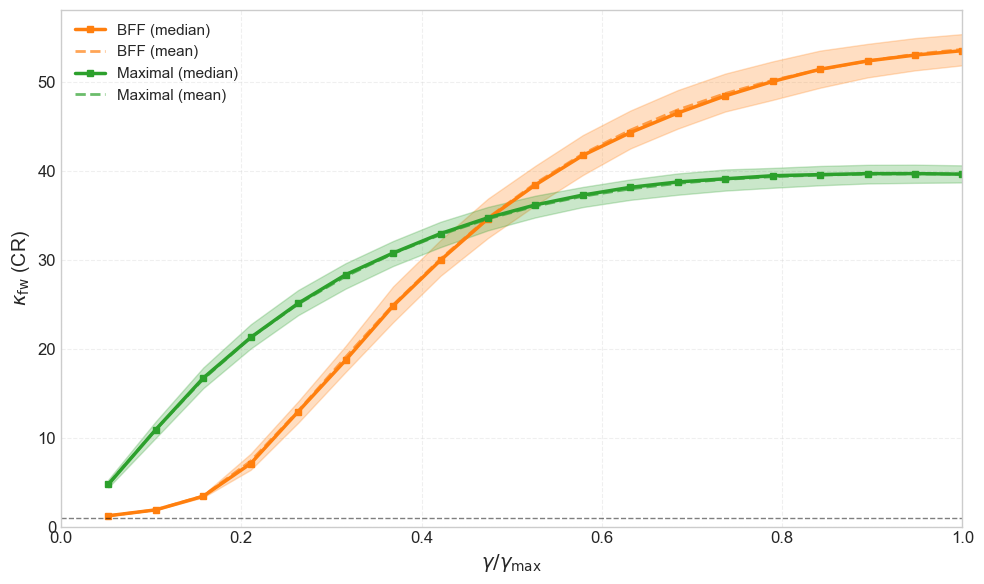

In [14]:
print("Creating CR vs Gamma visualization (Option 2: Shock Variability)...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask = gamma_normalized > 0  # Exclude gamma = 0

for method_name in ['BFF', 'Maximal']:
    cr_median = results_option2['methods'][method_name]['cr_median'][mask]
    cr_mean = results_option2['methods'][method_name]['cr_mean'][mask]
    cr_p25 = results_option2['methods'][method_name]['cr_p25'][mask]
    cr_p75 = results_option2['methods'][method_name]['cr_p75'][mask]

    # Plot median line (solid)
    ax.plot(gamma_normalized[mask], cr_median, linewidth=2.5,
            label=f'{method_name} (median)', marker='s', markersize=4,
            markevery=max(1, len(gamma_normalized[mask])//10),
            color=colors[method_name.lower()])
    
    # Plot mean line (dashed)
    ax.plot(gamma_normalized[mask], cr_mean, linewidth=2,
            linestyle='--', alpha=0.7,
            label=f'{method_name} (mean)',
            color=colors[method_name.lower()])

    # Fill 25-75 percentile band
    ax.fill_between(gamma_normalized[mask], cr_p25, cr_p75,
                    alpha=0.25, color=colors[method_name.lower()])

ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel(r'$\gamma / \gamma_{\mathrm{max}}$', fontsize=14)
ax.set_ylabel(r'$\kappa_{\mathrm{fw}}$ (CR)', fontsize=14)
# ax.set_title(f'Conservativeness Ratio vs Normalized Gamma - Shock Variability (p={p:.2f}, ρ={rho:.2f})',
#              fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(f'experiment3_results/Experiment3_figure_cr_vs_gamma_option2_p{p:.2f}_rho{rho:.2f}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: figure_cr_vs_gamma_option2_p{p:.2f}_rho{rho:.2f}.png")
plt.show()

## 11b. Individual Shock Trajectories: CR (Option 2)

Show individual shock scenario responses for CR metric (after averaging over networks).

Creating individual CR trajectory plot (Option 2: Shock Variability)...
✓ Saved: Experiment3_CR_individual_trajectory_option2_p0.50_rho0.50.png


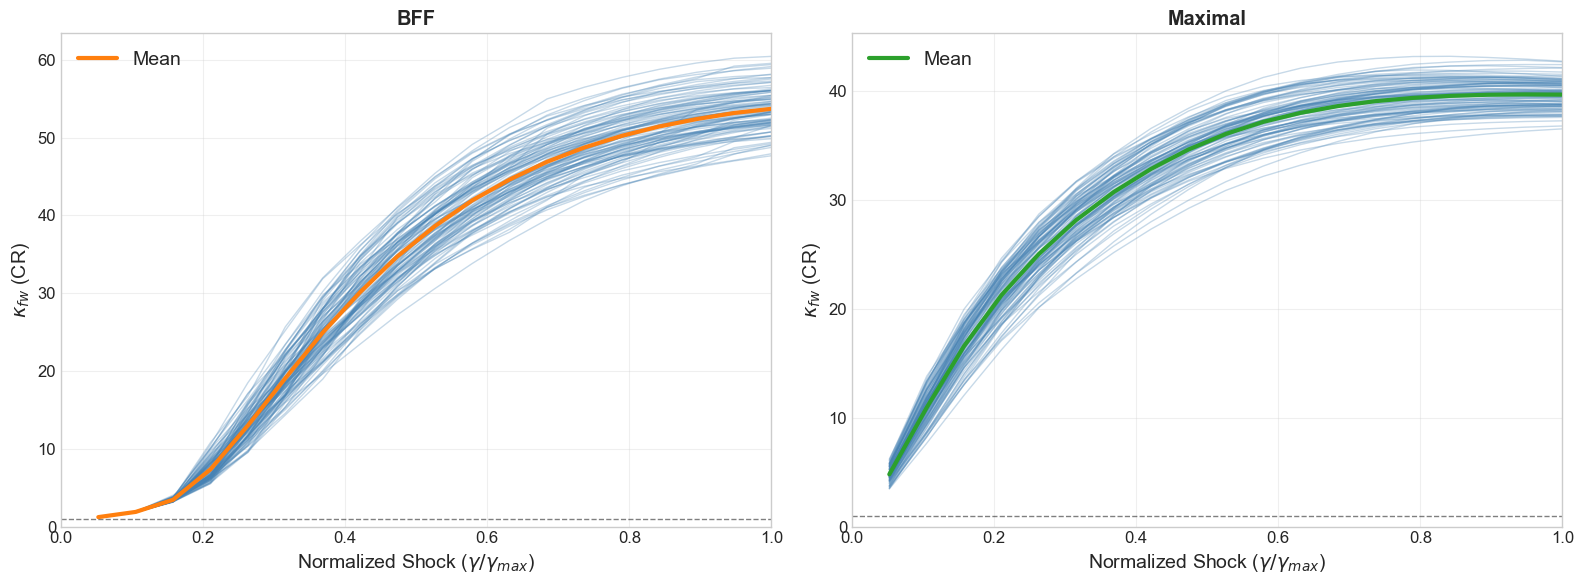

In [15]:
print("Creating individual CR trajectory plot (Option 2: Shock Variability)...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

mask = gamma_normalized > 0  # Exclude gamma = 0

# Plot 1: BFF
if 'BFF' in results_option2['methods']:
    cr_shocks = results_option2['methods']['BFF']['cr_all_shocks']  # (NUM_GAMMA, NUM_SHOCKS)
    cr_mean = results_option2['methods']['BFF']['cr_mean']
    
    # Plot individual shock trajectories
    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        ax1.plot(gamma_normalized[mask], cr_shocks[mask, shock_idx],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax1.plot(gamma_normalized[mask], cr_mean[mask],
            linewidth=3, color='#ff7f0e', label='Mean', zorder=10)
    ax1.axhline(1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax1.set_ylabel(r'$\kappa_{fw}$ (CR)', fontsize=14)
    ax1.set_title(f'BFF', fontweight='bold')
    ax1.legend(fontsize=14, loc='best')
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(bottom=0)

# Plot 2: Maximal
if 'Maximal' in results_option2['methods']:
    cr_shocks = results_option2['methods']['Maximal']['cr_all_shocks']  # (NUM_GAMMA, NUM_SHOCKS)
    cr_mean = results_option2['methods']['Maximal']['cr_mean']
    
    # Plot individual shock trajectories
    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        ax2.plot(gamma_normalized[mask], cr_shocks[mask, shock_idx],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax2.plot(gamma_normalized[mask], cr_mean[mask],
            linewidth=3, color='#2ca02c', label='Mean', zorder=10)
    ax2.axhline(1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax2.set_ylabel(r'$\kappa_{fw}$ (CR)', fontsize=14)
    ax2.set_title(f'Maximal', fontweight='bold')
    ax2.legend(fontsize=14, loc='best')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(f'experiment3_results/Experiment3_CR_individual_trajectory_option2_p{p:.2f}_rho{rho:.2f}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: Experiment3_CR_individual_trajectory_option2_p{p:.2f}_rho{rho:.2f}.png")
plt.show()

## 11. Visualization 4: CR vs Normalized Gamma (Option 2)

**Shock Variability**: Shows median (solid) and mean (dashed) with 25-75 percentile bands.

## 10. Visualization 3: ERLS vs Normalized Gamma (Option 2)

**Shock Variability**: Shows median (solid) and mean (dashed) with 25-75 percentile bands.

## 12. Summary Statistics

In [16]:
print("="*70)
print("EXPERIMENT 3 SUMMARY (Network Variability Style)")
print("="*70)
print()
print(f"Configuration:")
print(f"  Networks: {NUM_NETWORKS}")
print(f"  Shocks per network: {NUM_SHOCK_SCENARIOS}")
print(f"  Network size: {N_total} nodes")
print(f"  Connection probability: p = {p}")
print(f"  Shock correlation: ρ = {rho}")
print(f"  Gamma range: [0, {gamma_max:.4f}] (normalized to [0, 1])")
print(f"  Total simulations: {NUM_NETWORKS * NUM_SHOCK_SCENARIOS * NUM_GAMMA_POINTS * 3:,}")
print()
print("="*70)
print("OPTION 1: NETWORK VARIABILITY")
print("  (Average over shocks first, then stats across networks)")
print("="*70)

for method_name in ['BFF', 'Maximal']:
    erls_overall = results_option1['methods'][method_name]['erls_mean'].mean()
    erls_median_overall = results_option1['methods'][method_name]['erls_median'].mean()
    cr_overall = results_option1['methods'][method_name]['cr_mean'].mean()
    cr_median_overall = results_option1['methods'][method_name]['cr_median'].mean()
    flow_retained = results_option1['methods'][method_name]['flow_retained']
    
    # Count negative ERLS
    erls_values = results_option1['methods'][method_name]['erls_mean']
    neg_erls_pct = (erls_values < 0).sum() / len(erls_values) * 100
    
    print(f"\n{method_name}:")
    print(f"  Mean ERLS: {erls_overall:.3f}")
    print(f"  Median ERLS: {erls_median_overall:.3f}")
    print(f"  Mean CR: {cr_overall:.3f}")
    print(f"  Median CR: {cr_median_overall:.3f}")
    print(f"  Flow retained: {flow_retained:.1%}")
    print(f"  Negative ERLS points: {neg_erls_pct:.1f}%")

print()
print("="*70)
print("OPTION 2: SHOCK VARIABILITY")
print("  (Average over networks first, then stats across shocks)")
print("="*70)

for method_name in ['BFF', 'Maximal']:
    erls_overall = results_option2['methods'][method_name]['erls_mean'].mean()
    erls_median_overall = results_option2['methods'][method_name]['erls_median'].mean()
    cr_overall = results_option2['methods'][method_name]['cr_mean'].mean()
    cr_median_overall = results_option2['methods'][method_name]['cr_median'].mean()
    flow_retained = results_option2['methods'][method_name]['flow_retained']
    
    # Count negative ERLS
    erls_values = results_option2['methods'][method_name]['erls_mean']
    neg_erls_pct = (erls_values < 0).sum() / len(erls_values) * 100
    
    print(f"\n{method_name}:")
    print(f"  Mean ERLS: {erls_overall:.3f}")
    print(f"  Median ERLS: {erls_median_overall:.3f}")
    print(f"  Mean CR: {cr_overall:.3f}")
    print(f"  Median CR: {cr_median_overall:.3f}")
    print(f"  Flow retained: {flow_retained:.1%}")
    print(f"  Negative ERLS points: {neg_erls_pct:.1f}%")

print()
print("="*70)
print("VISUALIZATIONS GENERATED")
print("="*70)
print(f"  Option 1 (Network Variability):")
print(f"    - Experiment3_figure_erls_vs_gamma_option1_p{p:.2f}_rho{rho:.2f}.png")
print(f"    - Experiment3_figure_cr_vs_gamma_option1_p{p:.2f}_rho{rho:.2f}.png")
print(f"    - Experiment3_ERLS_individual_trajectory_option1_p{p:.2f}_rho{rho:.2f}.png (NEW)")
print(f"    - Experiment3_CR_individual_trajectory_option1_p{p:.2f}_rho{rho:.2f}.png (NEW)")
print()
print(f"  Option 2 (Shock Variability):")
print(f"    - Experiment3_figure_erls_vs_gamma_option2_p{p:.2f}_rho{rho:.2f}.png")
print(f"    - Experiment3_figure_cr_vs_gamma_option2_p{p:.2f}_rho{rho:.2f}.png")
print(f"    - Experiment3_ERLS_individual_trajectory_option2_p{p:.2f}_rho{rho:.2f}.png (NEW)")
print(f"    - Experiment3_CR_individual_trajectory_option2_p{p:.2f}_rho{rho:.2f}.png (NEW)")
print()
print("Key Features:")
print("  - Adaptive buffers: b = α × W.sum(axis=1)")
print("  - Gaussian Copula shocks with Spearman's ρ")
print("  - ERLS formula: (α*_orig × W_orig_sum - α*_comp × W_comp_sum) / (α*_orig × W_orig_sum)")
print("  - Both median (solid) and mean (dashed) shown")
print("  - Shaded bands: 25-75 percentile")
print("  - Individual trajectory plots: Light blue lines for each network/shock")
print("="*70)

EXPERIMENT 3 SUMMARY (Network Variability Style)

Configuration:
  Networks: 500
  Shocks per network: 100
  Network size: 55 nodes
  Connection probability: p = 0.5
  Shock correlation: ρ = 0.5
  Gamma range: [0, 136.7915] (normalized to [0, 1])
  Total simulations: 3,000,000

OPTION 1: NETWORK VARIABILITY
  (Average over shocks first, then stats across networks)

BFF:
  Mean ERLS: -6.884
  Median ERLS: -2.568
  Mean CR: 30.808
  Median CR: 13.763
  Flow retained: 25.8%
  Negative ERLS points: 80.0%

Maximal:
  Mean ERLS: -5.172
  Median ERLS: -2.527
  Mean CR: 29.525
  Median CR: 16.470
  Flow retained: 21.4%
  Negative ERLS points: 90.0%

OPTION 2: SHOCK VARIABILITY
  (Average over networks first, then stats across shocks)

BFF:
  Mean ERLS: -6.990
  Median ERLS: -6.956
  Mean CR: 30.926
  Median CR: 30.793
  Flow retained: 25.8%
  Negative ERLS points: 80.0%

Maximal:
  Mean ERLS: -5.337
  Median ERLS: -5.354
  Mean CR: 29.643
  Median CR: 29.723
  Flow retained: 21.4%
  Negative E